In [297]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import collections
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from textblob import TextBlob
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Todo Create a Table of Contents

# Todo Look at better way to tokenize data? If have more time, for for now use the assignment ways.
# https://towardsdatascience.com/an-introduction-to-tweettokenizer-for-processing-tweets-9879389f8fe7

# Just use tweet tokenizer instead? We can look at that and compare results later.

# Big boy / future work: Also analyze the links they include in their tweets, and what they point to. This can then be used for topic modelling and
# Seeing what they tweet about. E.g biden tweet id 1286423343135182848 'This was preventable, link'; links to covid19 cases in USA. Don't know that he's talking
# about that unless you know the content of the link.
# You could potentially analyze the links they include in their tweets, news sources, etc. 

In [65]:
# TOC:
    # 1. lOAD dATA
     # 1.1 ... 
    # 2 Sentiment Analysis
    # 3 Topic Modelling
    # 4 Classification

# Function Definitions for Various Tasks
## Code Adapted from [TA's video](https://www.youtube.com/watch?v=Cz2hSCEDJqs&feature=youtu.be)

In [3]:
global stop_words
stop_words = stopwords.words('english')
custom_stopwords = ['amp', 'youre', 'dont','wont', 'got']
stop_words.extend(custom_stopwords)

def remove_url_punctuation(X):
    """ Replace URLS, punctuations, hashtags found in a text string with nothing.
    Change to lowercase"""
    # Try with just simple /w+ regex.       
    url_pattern = re.compile(r'https:?://\S+|www\.\S+')
    replace_url = url_pattern.sub(r'', str(X))
    punct_pattern = re.compile(r'[^\w\s]')
    no_punct = punct_pattern.sub(r'', replace_url).lower()
    no_punct = no_punct.replace('\n', ' ')
    no_punct = no_punct.replace('\t', ' ')
    return no_punct

def split_words(X):
    """"" Split tweets into words for NLP"""
    split_word_list = X.split(" ")
    return split_word_list

def remove_stopwords(X):
    filtered_words = []
    global stop_words
    for word in X:
        if word not in stop_words and len(word) > 2 and word != 'nan':
            filtered_words.append(word)
    return filtered_words

# Load the data

In [4]:
trump_df = pd.read_csv("trump.csv")
biden_df = pd.read_csv("biden.csv")

In [221]:
trump_df

,text,created_at,retweet_count,favorite_count,is_retweet,id_str,clean_text,tokens,Subjectivity,Polarity,Sentiment,POS_TAGS,processed_tokens
0,I am deeply saddened by the loss of my friend ...,07-22-2020 22:46:27,24836,126563,False,1286070129965649922,i am deeply saddened by the loss of my friend ...,"[deeply, saddened, loss, friend, charles, ever...",0.400000,0.000000,Neutral,"[(i, NN), (am, VBP), (deeply, RB), (saddened, ...","[deepli, sadden, loss, friend, charl, ever, ch..."
1,We MUST protect our National Parks for our chi...,07-22-2020 19:32:42,31289,155074,False,1286021372070830084,we must protect our national parks for our chi...,"[must, protect, national, parks, children, gra...",0.237500,0.250000,Positive,"[(we, PRP), (must, MD), (protect, VB), (our, P...","[protect, nation, park, child, grandchild, cal..."
2,Mail-In Voting unless changed by the courts wi...,07-21-2020 11:41:10,45537,172449,False,1285540318503407622,mailin voting unless changed by the courts wil...,"[mailin, voting, unless, changed, courts, lead...",0.750000,0.000000,Neutral,"[(mailin, NN), (voting, NN), (unless, IN), (ch...","[mailin, vote, chang, court, lead, corrupt, el..."
3,Strong Stock Market Numbers. You want to see t...,07-21-2020 11:33:05,30439,147781,False,1285538283892748288,strong stock market numbers you want to see th...,"[strong, stock, market, numbers, want, see, di...",0.277778,0.144444,Positive,"[(strong, JJ), (stock, NN), (market, NN), (num...","[strong, stock, market, number, want, dive, vo..."
4,“In my view General Flynn should never have be...,07-21-2020 10:48:12,21231,90140,False,1285526989667958784,in my view general flynn should never have bee...,"[view, general, flynn, never, prosecuted, firs...",0.416667,0.150000,Positive,"[(in, IN), (my, PRP$), (view, NN), (general, J...","[view, general, flynn, prosecut, place, judgen..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5181,I will be signing our very large and comprehen...,12-31-2019 14:16:40,22730,95208,False,1212014713808273410,i will be signing our very large and comprehen...,"[signing, large, comprehensive, phase, one, tr...",0.219429,0.087714,Positive,"[(i, NN), (will, MD), (be, VB), (signing, VBG)...","[sign, larg, comprehens, phase, trade, deal, c..."
5182,President Putin of Russia called to thank me a...,12-31-2019 14:06:09,29025,141918,False,1212012065440894976,president putin of russia called to thank me a...,"[president, putin, russia, called, thank, info...",0.729167,0.588889,Positive,"[(president, NN), (putin, NN), (of, IN), (russ...","[presid, putin, russia, call, thank, inform, p..."
5183,Armed congregants quickly stopped a crazed chu...,12-31-2019 13:53:10,25719,114701,False,1212008798849814528,armed congregants quickly stopped a crazed chu...,"[armed, congregants, quickly, stopped, crazed,...",0.380000,0.164444,Positive,"[(armed, VBN), (congregants, NNS), (quickly, R...","[arm, congreg, quick, stop, craze, church, sho..."
5184,Iran killed an American contractor wounding ma...,12-31-2019 12:02:47,37287,150318,False,1211981022084128768,iran killed an american contractor wounding ma...,"[iran, killed, american, contractor, wounding,...",0.356667,0.186667,Positive,"[(iran, NN), (killed, VBD), (an, DT), (america...","[iran, kill, american, contractor, wound, stro..."


In [6]:
biden_df

,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Donald Trump’s own staff admits that he fails ...,2020-07-24 00:30:00,4867,19073,False,1286458575150370817
1,We need a president who listens to someone oth...,2020-07-23 23:15:00,15827,110536,False,1286439700958453763
2,This was preventable. https://t.co/NWaHXW8U4K,2020-07-23 22:10:00,12336,56418,False,1286423343135182848
3,"Out of every trial and tribulation, we've alwa...",2020-07-23 21:40:00,4158,12282,False,1286415793245347845
4,"Hey @Phillies, here’s to hoping we both win bi...",2020-07-23 20:05:00,4914,35253,False,1286391885993373696
...,...,...,...,...,...,...
3087,President Trump’s ICE raids are inhumane. His ...,2019-07-13 20:55:00,3886,19173,False,1150146631569989633
3088,I’m heartbroken to hear of the passing of Héct...,2019-07-13 19:55:00,200,1299,False,1150131532092383232
3089,Had the opportunity to spend some time with th...,2019-07-13 19:19:12,167,885,False,1150122523075457025
3090,"As individuals, and as a nation, we have to pr...",2019-07-13 17:13:00,520,2076,False,1150090763214004224


# Data cleaning and preparation

## Remove Punctuation, special characters, and hashtags in tweets

In [27]:
trump_df['clean_text'] = trump_df['text'].apply(remove_url_punctuation)
biden_df['clean_text'] = biden_df['text'].apply(remove_url_punctuation)
print(trump_df['clean_text'].head())
print('-------------------------------------')
print(biden_df['clean_text'].head())

0    i am deeply saddened by the loss of my friend ...
1    we must protect our national parks for our chi...
2    mailin voting unless changed by the courts wil...
3    strong stock market numbers you want to see th...
4    in my view general flynn should never have bee...
Name: clean_text, dtype: object
-------------------------------------
0    donald trumps own staff admits that he fails t...
1    we need a president who listens to someone oth...
2                                this was preventable 
3    out of every trial and tribulation weve always...
4    hey phillies heres to hoping we both win big t...
Name: clean_text, dtype: object


## Tokenize Tweets

In [28]:
trump_df['tokens'] = trump_df['clean_text'].apply(split_words)
biden_df['tokens'] = biden_df['clean_text'].apply(split_words)
print(trump_df['tokens'].head())
print('-------------------------------------')
print(biden_df['tokens'].head())

0    [i, am, deeply, saddened, by, the, loss, of, m...
1    [we, must, protect, our, national, parks, for,...
2    [mailin, voting, unless, changed, by, the, cou...
3    [strong, stock, market, numbers, you, want, to...
4    [in, my, view, general, flynn, should, never, ...
Name: tokens, dtype: object
-------------------------------------
0    [donald, trumps, own, staff, admits, that, he,...
1    [we, need, a, president, who, listens, to, som...
2                           [this, was, preventable, ]
3    [out, of, every, trial, and, tribulation, weve...
4    [hey, phillies, heres, to, hoping, we, both, w...
Name: tokens, dtype: object


## Remove Stop Words with NLTK

In [29]:
trump_df['tokens'] = trump_df['tokens'].apply(remove_stopwords)
biden_df['tokens'] = biden_df['tokens'].apply(remove_stopwords)

print(trump_df['tokens'].head())
print('-----------------------')
print(biden_df['tokens'].head())

0    [deeply, saddened, loss, friend, charles, ever...
1    [must, protect, national, parks, children, gra...
2    [mailin, voting, unless, changed, courts, lead...
3    [strong, stock, market, numbers, want, see, di...
4    [view, general, flynn, never, prosecuted, firs...
Name: tokens, dtype: object
-----------------------
0    [donald, trumps, staff, admits, fails, importa...
1                  [need, president, listens, someone]
2                                        [preventable]
3    [every, trial, tribulation, weve, always, emer...
4    [hey, phillies, heres, hoping, win, big, fall,...
Name: tokens, dtype: object


In [298]:
biden_df

,text,created_at,retweet_count,favorite_count,is_retweet,id_str,clean_text,tokens,Subjectivity,Polarity,Sentiment
0,Donald Trump’s own staff admits that he fails ...,2020-07-24 00:30:00,4867,19073,False,1286458575150370817,donald trumps own staff admits that he fails t...,"[donald, trumps, staff, admits, fails, importa...",0.560000,0.200000,Positive
1,We need a president who listens to someone oth...,2020-07-23 23:15:00,15827,110536,False,1286439700958453763,we need a president who listens to someone oth...,"[need, president, listens, someone]",0.375000,-0.125000,Negative
2,This was preventable. https://t.co/NWaHXW8U4K,2020-07-23 22:10:00,12336,56418,False,1286423343135182848,this was preventable,[preventable],0.000000,0.000000,Neutral
3,"Out of every trial and tribulation, we've alwa...",2020-07-23 21:40:00,4158,12282,False,1286415793245347845,out of every trial and tribulation weve always...,"[every, trial, tribulation, weve, always, emer...",0.214286,0.035714,Positive
4,"Hey @Phillies, here’s to hoping we both win bi...",2020-07-23 20:05:00,4914,35253,False,1286391885993373696,hey phillies heres to hoping we both win big t...,"[hey, phillies, heres, hoping, win, big, fall,...",0.333333,0.433333,Positive
...,...,...,...,...,...,...,...,...,...,...,...
3087,President Trump’s ICE raids are inhumane. His ...,2019-07-13 20:55:00,3886,19173,False,1150146631569989633,president trumps ice raids are inhumane his sc...,"[president, trumps, ice, raids, inhumane, scar...",0.450000,-0.450000,Negative
3088,I’m heartbroken to hear of the passing of Héct...,2019-07-13 19:55:00,200,1299,False,1150131532092383232,im heartbroken to hear of the passing of hécto...,"[heartbroken, hear, passing, héctor, figueroa,...",0.800000,0.700000,Positive
3089,Had the opportunity to spend some time with th...,2019-07-13 19:19:12,167,885,False,1150122523075457025,had the opportunity to spend some time with th...,"[opportunity, spend, time, great, residents, a...",0.676136,0.584091,Positive
3090,"As individuals, and as a nation, we have to pr...",2019-07-13 17:13:00,520,2076,False,1150090763214004224,as individuals and as a nation we have to prov...,"[individuals, nation, prove, world, united, st...",0.000000,0.000000,Neutral


# Sentiment Analysis

In [101]:
# Measure subjectivity of a text. Subjectivity is in the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Use polarity as a measure for sentiment. Polarity is in the range [-1.0, 1.0] where -1 is negative and +1 is positive sentiment
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

## Get polarity and subjectivity scores for candidate tweets

In [102]:
trump_df['Subjectivity'] = trump_df['clean_text'].apply(get_subjectivity)
trump_df['Polarity'] = trump_df['clean_text'].apply(get_polarity)

biden_df['Subjectivity'] = biden_df['clean_text'].apply(get_subjectivity)
biden_df['Polarity'] = biden_df['clean_text'].apply(get_polarity)

In [103]:
trump_df

,text,created_at,retweet_count,favorite_count,is_retweet,id_str,clean_text,tokens,Subjectivity,Polarity,Sentiment
0,I am deeply saddened by the loss of my friend ...,07-22-2020 22:46:27,24836,126563,False,1286070129965649922,i am deeply saddened by the loss of my friend ...,"[deeply, saddened, loss, friend, charles, ever...",0.400000,0.000000,Neutral
1,We MUST protect our National Parks for our chi...,07-22-2020 19:32:42,31289,155074,False,1286021372070830084,we must protect our national parks for our chi...,"[must, protect, national, parks, children, gra...",0.237500,0.250000,Positive
2,Mail-In Voting unless changed by the courts wi...,07-21-2020 11:41:10,45537,172449,False,1285540318503407622,mailin voting unless changed by the courts wil...,"[mailin, voting, unless, changed, courts, lead...",0.750000,0.000000,Neutral
3,Strong Stock Market Numbers. You want to see t...,07-21-2020 11:33:05,30439,147781,False,1285538283892748288,strong stock market numbers you want to see th...,"[strong, stock, market, numbers, want, see, di...",0.277778,0.144444,Positive
4,“In my view General Flynn should never have be...,07-21-2020 10:48:12,21231,90140,False,1285526989667958784,in my view general flynn should never have bee...,"[view, general, flynn, never, prosecuted, firs...",0.416667,0.150000,Positive
...,...,...,...,...,...,...,...,...,...,...,...
5181,I will be signing our very large and comprehen...,12-31-2019 14:16:40,22730,95208,False,1212014713808273410,i will be signing our very large and comprehen...,"[signing, large, comprehensive, phase, one, tr...",0.219429,0.087714,Positive
5182,President Putin of Russia called to thank me a...,12-31-2019 14:06:09,29025,141918,False,1212012065440894976,president putin of russia called to thank me a...,"[president, putin, russia, called, thank, info...",0.729167,0.588889,Positive
5183,Armed congregants quickly stopped a crazed chu...,12-31-2019 13:53:10,25719,114701,False,1212008798849814528,armed congregants quickly stopped a crazed chu...,"[armed, congregants, quickly, stopped, crazed,...",0.380000,0.164444,Positive
5184,Iran killed an American contractor wounding ma...,12-31-2019 12:02:47,37287,150318,False,1211981022084128768,iran killed an american contractor wounding ma...,"[iran, killed, american, contractor, wounding,...",0.356667,0.186667,Positive


In [100]:
# Function to assign positive, neutral, and negative labels to tweets based on polarity
def get_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [52]:
trump_df['Sentiment'] = trump_df['Polarity'].apply(get_sentiment)
biden_df['Sentiment'] = biden_df['Polarity'].apply(get_sentiment)

trump_df

,text,created_at,retweet_count,favorite_count,is_retweet,id_str,clean_text,tokens,Subjectivity,Polarity,Sentiment
0,I am deeply saddened by the loss of my friend ...,07-22-2020 22:46:27,24836,126563,False,1286070129965649922,i am deeply saddened by the loss of my friend ...,"[deeply, saddened, loss, friend, charles, ever...",0.400000,0.000000,Neutral
1,We MUST protect our National Parks for our chi...,07-22-2020 19:32:42,31289,155074,False,1286021372070830084,we must protect our national parks for our chi...,"[must, protect, national, parks, children, gra...",0.237500,0.250000,Positive
2,Mail-In Voting unless changed by the courts wi...,07-21-2020 11:41:10,45537,172449,False,1285540318503407622,mailin voting unless changed by the courts wil...,"[mailin, voting, unless, changed, courts, lead...",0.750000,0.000000,Neutral
3,Strong Stock Market Numbers. You want to see t...,07-21-2020 11:33:05,30439,147781,False,1285538283892748288,strong stock market numbers you want to see th...,"[strong, stock, market, numbers, want, see, di...",0.277778,0.144444,Positive
4,“In my view General Flynn should never have be...,07-21-2020 10:48:12,21231,90140,False,1285526989667958784,in my view general flynn should never have bee...,"[view, general, flynn, never, prosecuted, firs...",0.416667,0.150000,Positive
...,...,...,...,...,...,...,...,...,...,...,...
5181,I will be signing our very large and comprehen...,12-31-2019 14:16:40,22730,95208,False,1212014713808273410,i will be signing our very large and comprehen...,"[signing, large, comprehensive, phase, one, tr...",0.219429,0.087714,Positive
5182,President Putin of Russia called to thank me a...,12-31-2019 14:06:09,29025,141918,False,1212012065440894976,president putin of russia called to thank me a...,"[president, putin, russia, called, thank, info...",0.729167,0.588889,Positive
5183,Armed congregants quickly stopped a crazed chu...,12-31-2019 13:53:10,25719,114701,False,1212008798849814528,armed congregants quickly stopped a crazed chu...,"[armed, congregants, quickly, stopped, crazed,...",0.380000,0.164444,Positive
5184,Iran killed an American contractor wounding ma...,12-31-2019 12:02:47,37287,150318,False,1211981022084128768,iran killed an american contractor wounding ma...,"[iran, killed, american, contractor, wounding,...",0.356667,0.186667,Positive


In [53]:
biden_df

,text,created_at,retweet_count,favorite_count,is_retweet,id_str,clean_text,tokens,Subjectivity,Polarity,Sentiment
0,Donald Trump’s own staff admits that he fails ...,2020-07-24 00:30:00,4867,19073,False,1286458575150370817,donald trumps own staff admits that he fails t...,"[donald, trumps, staff, admits, fails, importa...",0.560000,0.200000,Positive
1,We need a president who listens to someone oth...,2020-07-23 23:15:00,15827,110536,False,1286439700958453763,we need a president who listens to someone oth...,"[need, president, listens, someone]",0.375000,-0.125000,Negative
2,This was preventable. https://t.co/NWaHXW8U4K,2020-07-23 22:10:00,12336,56418,False,1286423343135182848,this was preventable,[preventable],0.000000,0.000000,Neutral
3,"Out of every trial and tribulation, we've alwa...",2020-07-23 21:40:00,4158,12282,False,1286415793245347845,out of every trial and tribulation weve always...,"[every, trial, tribulation, weve, always, emer...",0.214286,0.035714,Positive
4,"Hey @Phillies, here’s to hoping we both win bi...",2020-07-23 20:05:00,4914,35253,False,1286391885993373696,hey phillies heres to hoping we both win big t...,"[hey, phillies, heres, hoping, win, big, fall,...",0.333333,0.433333,Positive
...,...,...,...,...,...,...,...,...,...,...,...
3087,President Trump’s ICE raids are inhumane. His ...,2019-07-13 20:55:00,3886,19173,False,1150146631569989633,president trumps ice raids are inhumane his sc...,"[president, trumps, ice, raids, inhumane, scar...",0.450000,-0.450000,Negative
3088,I’m heartbroken to hear of the passing of Héct...,2019-07-13 19:55:00,200,1299,False,1150131532092383232,im heartbroken to hear of the passing of hécto...,"[heartbroken, hear, passing, héctor, figueroa,...",0.800000,0.700000,Positive
3089,Had the opportunity to spend some time with th...,2019-07-13 19:19:12,167,885,False,1150122523075457025,had the opportunity to spend some time with th...,"[opportunity, spend, time, great, residents, a...",0.676136,0.584091,Positive
3090,"As individuals, and as a nation, we have to pr...",2019-07-13 17:13:00,520,2076,False,1150090763214004224,as individuals and as a nation we have to prov...,"[individuals, nation, prove, world, united, st...",0.000000,0.000000,Neutral


# Todo: Get top 100 most positive and negative tweets of each candidate.

In [58]:
print('Printing Trump positive tweets:\n')
j=1
sortedDF = trump_df.sort_values(by=['Polarity']) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Sentiment'][i] == 'Positive'):
    print(str(j) + ') '+ sortedDF['text'][i])
    print()
    j= j+1

Printing positive tweets:

1) We MUST protect our National Parks for our children and grandchildren. I am calling on the House to pass the GREAT AMERICAN OUTDOORS ACT today. Thanks @SenCoryGardner and @SteveDaines for all your work on this HISTORIC BILL!

2) Strong Stock Market Numbers. You want to see them dive? Vote for the Radical Left with their BIG Tax Hikes!

3) “In my view General Flynn should never have been prosecuted in the first place.” @Judgenap Judge Andrew Napolitano  @foxandfriends

4) You will never hear this on the Fake News concerning the China Virus but by comparison to most other countries who are suffering greatly we are doing very well - and we have done things that few other countries could have done!

5) Tremendous progress being made on Vaccines and Therapeutics!!!

6) Looking forward to live sports but any time I witness a player kneeling during the National Anthem a sign of great disrespect for our Country and our Flag the game is over for me!

7) Thank you f

1203) The world is at war with a hidden enemy. WE WILL WIN! https://t.co/QLceNWcL6Z

1204) Our great Oil &amp; Gas industry is under under seige after having one of the best years in recorded history. It will get better than ever as soon as our Country starts up again. Vital that it does for our National Security!

1205) RT @WhiteHouse: Thank you to the American People for continuing to practice social distancing. By staying home you are saving lives. htt…

1206) RT @WhiteHouse: LIVE: Press Briefing with Coronavirus Task Force https://t.co/Z8tK225cN6

1207) I will be doing a News Conference live from the @WhiteHouse at 5:00 P.M. (Eastern) to discuss the mtg of the G20 Leaders that took place this morning at 7:55 A.M. by World Teleconference. Also my 12:00 P.M. Teleconference call w/50 Governors plus Territories will be discussed.

1208) The LameStream Media is the dominant force in trying to get me to keep our Country closed as long as possible in the hope that it will be detrimental t

2342) RT @DailyCaller: Van Jones:“There was nothing I saw tonight that would be able to take Donald Trump out.”https://t.co/cj8e5JkYqW

2343) RT @michaeljknowles: If the election were held in the 24 hours after this #DemocraticDebate Trump would win every single state including…

2344) RT @kilmeade: .@jockowillink says President @realDonaldTrump's gamble ordering the strike that killed Soleimani was a brilliant move that k…

2345) Now up to 187 Federal Judges and two great new Supreme Court Justices. We are in major record territory. Hope EVERYONE is happy! https://t.co/ymEQljJyib

2346) RT @senatemajldr: First Democrats spent weeks saying the House case was totally convincing. Now the opposite: They say the House case is…

2347) RT @StumpforTrump: .@LindseyGrahamSC: “I’m really over with this. This whole thing is a joke. Nothing happened here. We’re not going to imp…

2348) RT @DevinNunes: Full blown McCarthyism on display... Did the Russians decide not to play in the 2018 elections s

In [59]:
print('Printing Biden positive tweets:\n')
j=1
sortedDF = biden_df.sort_values(by=['Polarity']) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Sentiment'][i] == 'Positive'):
    print(str(j) + ') '+ sortedDF['text'][i])
    print()
    j= j+1

Printing Biden positive tweets:

1) Donald Trump’s own staff admits that he fails the most important test of being the American President: the duty to care — for you, for all of us. https://t.co/mJf0xhEYZ5

2) Out of every trial and tribulation, we've always emerged stronger as a nation — and we will again. If we come together, there is not a single thing we cannot accomplish. https://t.co/khTCfexgbX

3) Hey @Phillies, here’s to hoping we both win big this fall. Stay safe. #OpeningDay https://t.co/nGtdDVsrXv

4) Care jobs are ready to be filled right now, allowing millions of people — primarily women — to get back to work immediately.

It's the right thing to do for our families and our essential workers — and it's the smart thing to do for our economy. https://t.co/l598dnBp0O

5) Folks, I sat down with my friend President @BarackObama to discuss the significant moment we're in, who we are as a nation, and how we can build back better.   Watch our full conversation: https://t.co/n2P71L

1108) Less than 1% of our population risks everything to protect our country — the other 99% of us owe them more than we could ever repay. #VeteransDay https://t.co/ChF786cRlO

1109) Today, I’m releasing my plan to ensure our veterans receive what they deserve: our respect and enduring gratitude, and the benefits they have earned.  

Read my full plan: https://t.co/TCUYaKtz8l

1110) The most sacred obligation of our government is to do right by the men and women who defend our nation at war. Veterans Day offers us a moment to reflect on that obligation, and to recommit ourselves to all that it truly means. https://t.co/X0YAR8r3Xj

1111) We don’t say it enough — Barack Obama was a great president. And I’m proud to have worked alongside him. https://t.co/5pIZxkNxyj

1112) HBCUs and MSIs play a vital role in our communities. As president, I’ll invest $70 billion in these institutions to improve affordability, build high tech labs and facilities, and support student success.

Read my full 

In [60]:
print('Printing negative Trump tweets:\n')
j=1
sortedDF = trump_df.sort_values(by=['Polarity'],ascending=False) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Sentiment'][i] == 'Negative'):
    print(str(j) + ') '+sortedDF['text'][i])
    print()
    j=j+1

Printing negative tweets:

1) So we catch Obama &amp; Biden not to even mention the rest of their crew SPYING on my campaign AND NOTHING HAPPENS? I hope not! If it were the other way around 50 years for treason. NEVER FORGET!!!!

2) The Radical Left Democrats who totally control Biden will destroy our Country as we know it. Unimaginably bad things would happen to America. Look at Portland where the pols are just fine with 50 days of anarchy. We sent in help. Look at New York Chicago Philadelphia. NO!

3) Corrupt Joe Biden wants to defund our police. He may use different words but when you look at his pact with Crazy Bernie and other things that’s what he wants to do. It would destroy America!

4) I am the ultimate member of The Book of the Month Club. First I have lowlife dummy John Bolton a war mongering fool violating the law (he released massive amounts of Classified Information) and an NDA in order to build badly needed credibility and make a few dollars which

5) Another one of ma

In [61]:
print('Printing negative Biden tweets:\n')
j=1
sortedDF = biden_df.sort_values(by=['Polarity'],ascending=False) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Sentiment'][i] == 'Negative'):
    print(str(j) + ') '+sortedDF['text'][i])
    print()
    j=j+1

Printing negative Biden tweets:

1) We need a president who listens to someone other than himself.

2) Let me say what President Trump won't: Russian interference in our elections is a violation of our sovereignty. And if I’m president, I’ll respond accordingly. https://t.co/ZvkU7bbJ3r

3) Home health workers do God’s work, but aren’t paid much. They have few benefits, and 40% are still on SNAP or Medicaid. It's unacceptable.

I'll give caregivers and early childhood educators a much-needed raise.

4) Donald Trump simply doesn’t understand: We can’t deal with our economic crisis without solving the public health crisis.
 
And for all his bluster about his expertise on the economy, he is unable to explain how he will actually help the working families hit the hardest.

5) In honor of John Lewis, C.T. Vivian, and all the essential workers who have selflessly risked their lives, the Senate should pass a bill that ensures working people get real relief — extended unemployment insurance, re

# Visualize Sentiment Analysis

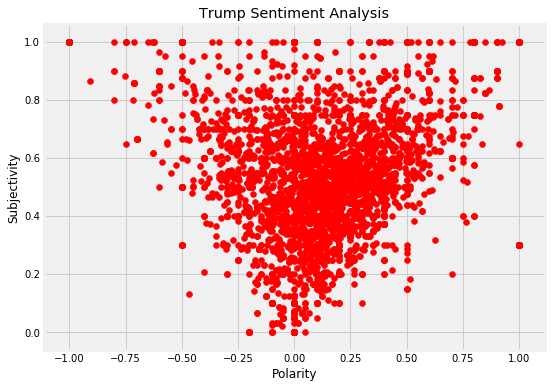

In [302]:
plt.figure(figsize=(8,6)) 
for i in range(0, len(trump_df)):
    plt.scatter(trump_df["Polarity"][i], trump_df["Subjectivity"][i], color='Red')
               
plt.title('Trump Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

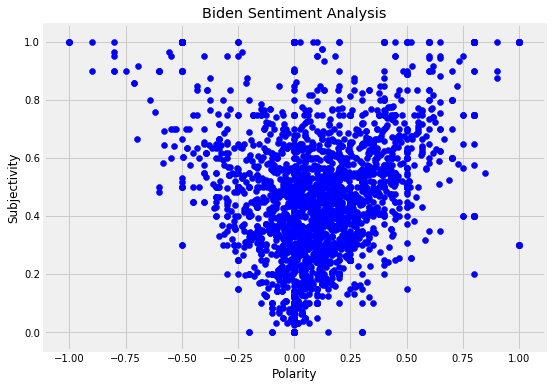

In [301]:
# Plotting 
plt.figure(figsize=(8,6)) 
for i in range(0, len(biden_df)):
    plt.scatter(biden_df["Polarity"][i], biden_df["Subjectivity"][i], color='Blue') 

plt.title('Biden Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

### View the counts of positive, netural, and negative tweets

In [303]:
trump_df['Sentiment'].value_counts()

Positive    2489
Neutral     1695
Negative    1002
Name: Sentiment, dtype: int64

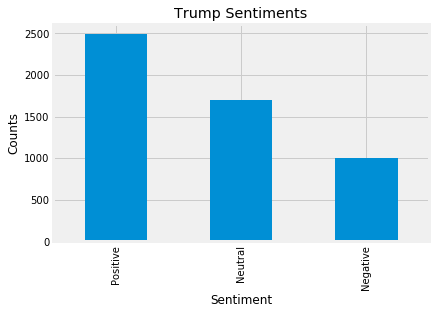

In [355]:
plt.title('Trump Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
trump_df['Sentiment'].value_counts().plot(kind = 'bar')
plt.show()

In [304]:
biden_df['Sentiment'].value_counts()

Positive    1661
Neutral      745
Negative     686
Name: Sentiment, dtype: int64

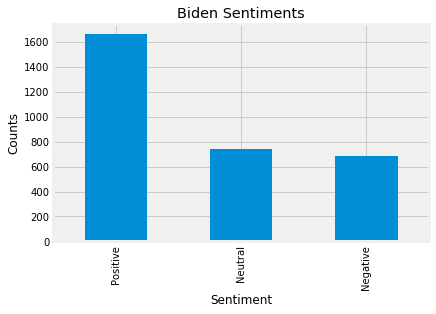

In [356]:
plt.title('Biden Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
biden_df['Sentiment'].value_counts().plot(kind = 'bar')
plt.show()

## Percentage of positive/negative tweets of each candidate

#### Trump

In [342]:
positive_trump_tweets = trump_df[trump_df.Sentiment == 'Positive']
positive_trump_percent = round(len(positive_trump_tweets) / len(trump_df) * 100, 2)
print(positive_trump_percent, '% of trump tweets are positive.')

47.99 % of trump tweets are positive.


In [343]:
# Get % of trump tweets that are neutral
neutral_trump_tweets = trump_df[trump_df.Sentiment == 'Neutral']
neutral_trump_percent = round(len(neutral_trump_tweets) / len(trump_df) * 100, 2)
print(neutral_trump_percent,'% of trump tweets are neutral.')

32.68 % of trump tweets are neutral.


In [344]:
negative_trump_tweets = trump_df[trump_df.Sentiment == 'Negative']
negative_trump_percent = round(len(negative_trump_tweets) / len(trump_df) * 100, 2)
print(negative_trump_percent, '% of trump tweets are negative.')

19.32 % of trump tweets are negative.


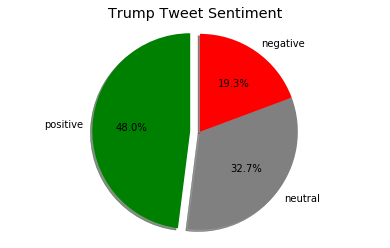

In [348]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sentiments = ['positive', 'neutral', 'negative']
percentages = [positive_trump_percent, neutral_trump_percent, negative_trump_percent]
explode = [0.1, 0, 0]

# TODO: Improve Color scheme
fig1, ax1 = plt.subplots()
ax1.pie(percentages, explode=explode, labels=sentiments, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['green', 'grey', 'red'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Trump Tweet Sentiment")
plt.show()

#### Biden

In [349]:
positive_biden_tweets = biden_df[biden_df.Sentiment == 'Positive']
positive_biden_percent = round(len(positive_biden_tweets) / len(biden_df) * 100, 2)
print(positive_biden_percent, '% of biden tweets are positive.')

53.72 % of biden tweets are positive.


In [350]:
neutral_biden_tweets = biden_df[biden_df.Sentiment == 'Neutral']
neutral_biden_percent = round(len(neutral_biden_tweets) / len(biden_df) * 100, 2)
print(neutral_biden_percent, '% of biden tweets are neutral.')

24.09 % of biden tweets are neutral.


In [351]:
negative_biden_tweets = biden_df[biden_df.Sentiment == 'Negative']
negative_biden_percent = round(len(negative_biden_tweets) / len(biden_df) * 100, 2)
print(negative_biden_percent, '% of biden tweets are negative.')

22.19 % of biden tweets are negative.


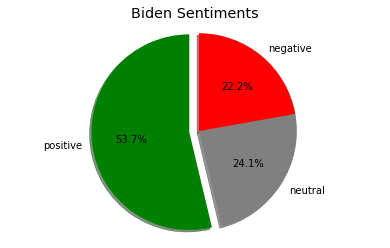

In [354]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sentiments = ['positive', 'neutral', 'negative']
percentages = [positive_biden_percent, neutral_biden_percent, negative_biden_percent]
explode = [0.1, 0, 0]

# TODO: Improve Color scheme
fig1, ax1 = plt.subplots()
ax1.pie(percentages, explode=explode, labels=sentiments, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['green', 'grey', 'red'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Biden Sentiments")
plt.show()

Here we observe a result I was not expecting: Biden's tweets are more polarizing than Trump's. 53.7% of Biden tweets are positive and 22.2% of them are negative, while Trump has a 48% positive rate and 19.3% negative rate.

# Todo: Did their sentiments change as the pandemic evolved?

Can plot sentiment over time: Polarity on the Y Axis, time on the X Axis. 

# Show their top 10 most favorited and retweeted tweets, top 10 most positive/ negative tweets.

In [98]:
# Show top 10 most frequent words found in their tweets, Count on x axis, words on y axis
# https://towardsdatascience.com/a-guide-to-mining-and-analysing-tweets-with-r-2f56818fdd16

In [111]:
# Get their top frequent words. 

# Topic Modeling with [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

In the literature, it seems that the biterm topic model (BTM) outperforms the traditional LDA algorithm for shorter text documents such as tweets [[source](https://www.cs.toronto.edu/~jstolee/projects/topic.pdf), [source](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.402.4032&rep=rep1&type=pdf)].

Future work can include comparing the results of these two models and seeing if we observe the suggested improvements. 


# Peprocess data for topic modelling
Remove words with fewer than three characters, perform lemmatization and stemming, 
# Remove words with fewer than 3 characters
# Perform lemmatization
# Perform stemming.
# In tokenization process, add min_len, to make sure tokens are > 3
# Need to do stemming else too many words in vocabulary for bow

In [249]:
# Define functions for topic model preprocessing

# TODO: look at token and find it's POS tag and then pass that into lemmatize, else by default it treats
# Every token as a noun, or as a verb if i leave it like this
# https://stackoverflow.com/questions/25534214/nltk-wordnet-lemmatizer-shouldnt-it-lemmatize-all-inflections-of-a-word

# TODO: POSSIBLY ADD TRUMPS TAG 

custom_trump_stopwords = ['realdonaldtrump', 'great']
# Note: Can try using other stemmers, but use snowball for now.
def stem_and_lemmatize(text):
    return SnowballStemmer("english").stem(WordNetLemmatizer().lemmatize(text))

def preprocess_tokens(tokens):
    result = []
    for token in tokens:
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in custom_trump_stopwords:
            result.append(stem_and_lemmatize(token))
    return result

In [250]:
trump_df

,text,created_at,retweet_count,favorite_count,is_retweet,id_str,clean_text,tokens,Subjectivity,Polarity,Sentiment,POS_TAGS,processed_tokens
0,I am deeply saddened by the loss of my friend ...,07-22-2020 22:46:27,24836,126563,False,1286070129965649922,i am deeply saddened by the loss of my friend ...,"[deeply, saddened, loss, friend, charles, ever...",0.400000,0.000000,Neutral,"[(i, NN), (am, VBP), (deeply, RB), (saddened, ...","[deepli, sadden, loss, friend, charl, ever, ch..."
1,We MUST protect our National Parks for our chi...,07-22-2020 19:32:42,31289,155074,False,1286021372070830084,we must protect our national parks for our chi...,"[must, protect, national, parks, children, gra...",0.237500,0.250000,Positive,"[(we, PRP), (must, MD), (protect, VB), (our, P...","[protect, nation, park, child, grandchild, cal..."
2,Mail-In Voting unless changed by the courts wi...,07-21-2020 11:41:10,45537,172449,False,1285540318503407622,mailin voting unless changed by the courts wil...,"[mailin, voting, unless, changed, courts, lead...",0.750000,0.000000,Neutral,"[(mailin, NN), (voting, NN), (unless, IN), (ch...","[mailin, vote, chang, court, lead, corrupt, el..."
3,Strong Stock Market Numbers. You want to see t...,07-21-2020 11:33:05,30439,147781,False,1285538283892748288,strong stock market numbers you want to see th...,"[strong, stock, market, numbers, want, see, di...",0.277778,0.144444,Positive,"[(strong, JJ), (stock, NN), (market, NN), (num...","[strong, stock, market, number, want, dive, vo..."
4,“In my view General Flynn should never have be...,07-21-2020 10:48:12,21231,90140,False,1285526989667958784,in my view general flynn should never have bee...,"[view, general, flynn, never, prosecuted, firs...",0.416667,0.150000,Positive,"[(in, IN), (my, PRP$), (view, NN), (general, J...","[view, general, flynn, prosecut, place, judgen..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5181,I will be signing our very large and comprehen...,12-31-2019 14:16:40,22730,95208,False,1212014713808273410,i will be signing our very large and comprehen...,"[signing, large, comprehensive, phase, one, tr...",0.219429,0.087714,Positive,"[(i, NN), (will, MD), (be, VB), (signing, VBG)...","[sign, larg, comprehens, phase, trade, deal, c..."
5182,President Putin of Russia called to thank me a...,12-31-2019 14:06:09,29025,141918,False,1212012065440894976,president putin of russia called to thank me a...,"[president, putin, russia, called, thank, info...",0.729167,0.588889,Positive,"[(president, NN), (putin, NN), (of, IN), (russ...","[presid, putin, russia, call, thank, inform, p..."
5183,Armed congregants quickly stopped a crazed chu...,12-31-2019 13:53:10,25719,114701,False,1212008798849814528,armed congregants quickly stopped a crazed chu...,"[armed, congregants, quickly, stopped, crazed,...",0.380000,0.164444,Positive,"[(armed, VBN), (congregants, NNS), (quickly, R...","[arm, congreg, quick, stop, craze, church, sho..."
5184,Iran killed an American contractor wounding ma...,12-31-2019 12:02:47,37287,150318,False,1211981022084128768,iran killed an american contractor wounding ma...,"[iran, killed, american, contractor, wounding,...",0.356667,0.186667,Positive,"[(iran, NN), (killed, VBD), (an, DT), (america...","[iran, kill, american, contractor, wound, stro..."


In [251]:
trump_df['processed_tokens'] = trump_df['tokens'].apply(preprocess_tokens)

In [252]:
trump_df['tokens'].head(20)

0     [deeply, saddened, loss, friend, charles, ever...
1     [must, protect, national, parks, children, gra...
2     [mailin, voting, unless, changed, courts, lead...
3     [strong, stock, market, numbers, want, see, di...
4     [view, general, flynn, never, prosecuted, firs...
5     [never, hear, fake, news, concerning, china, v...
6     [tremendous, progress, made, vaccines, therape...
7     [looking, forward, live, sports, time, witness...
8     [thank, good, reviews, comments, interview, ch...
9     [united, effort, defeat, invisible, china, vir...
10                 [congratulations, allen, great, job]
11    [catch, obama, biden, even, mention, rest, cre...
12    [radical, left, democrats, totally, control, b...
13    [trying, help, portland, hurt, leadership, mon...
14                               [make, america, great]
15    [oregon, officials, running, scared, comes, po...
16                                                   []
17    [saddened, hear, news, civil, rights, hero

In [253]:
trump_df['processed_tokens'].head(20)

0     [deepli, sadden, loss, friend, charl, ever, ch...
1     [protect, nation, park, child, grandchild, cal...
2     [mailin, vote, chang, court, lead, corrupt, el...
3     [strong, stock, market, number, want, dive, vo...
4     [view, general, flynn, prosecut, place, judgen...
5     [hear, fake, news, concern, china, virus, comp...
6                [tremend, progress, vaccin, therapeut]
7     [look, forward, live, sport, time, wit, player...
8     [thank, good, review, comment, interview, chri...
9     [unit, effort, defeat, invis, china, virus, pe...
10                                   [congratul, allen]
11    [catch, obama, biden, mention, rest, crew, spi...
12    [radic, left, democrat, total, control, biden,...
13    [tri, help, portland, hurt, leadership, month,...
14                                            [america]
15         [oregon, offici, run, scare, come, portland]
16                                                   []
17    [sadden, hear, news, civil, right, hero, j

In [254]:
trump_processed_tokens = trump_df['processed_tokens']

In [255]:
# Look at and learn gensim later, for now get the code working quickly and read more later.
dictionary = gensim.corpora.Dictionary(trump_processed_tokens)

In [256]:
dictionary

In [257]:
# Display top 10 most common?
# Kind of shitty can refactor this to be way better.
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 alongsid
1 blazer
2 brother
3 charl
4 civil
5 deepli
6 ever
7 fearless
8 friend
9 leader
10 loss


In [258]:
# Filter out tokens that appear in less than 15 docs or more than 0.5 documents, keep only the first 100000 most frequent tokens
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [259]:
bow_corpus = [dictionary.doc2bow(doc) for doc in trump_processed_tokens]

In [260]:
bow_corpus

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)],
 [(8, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1)],
 [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)],
 [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1)],
 [(33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)],
 [(41, 1), (42, 1), (43, 1)],
 [(8, 1),
  (34, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1)],
 [(10, 1),
  (39, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 2),
  (57, 1),
  (58, 1),
  (59, 1)],
 [(33, 1),
  (40, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 2),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1)],
 [(71, 1)],
 [(72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1)],
 [(21, 1),
  (24, 1),
  (34, 1),
  (39, 1),
  (48, 2),
  (72, 1),
  (74, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 

In [261]:
# Preview Bag Of Words for trumps 5th tweet
bow_tweet_5 = bow_corpus[5]
for i in range(len(bow_tweet_5)):
    print("Word {} (\"{}\") appears {} time.".format(bow_tweet_5[i][0], 
                                               dictionary[bow_tweet_5[i][0]], 
bow_tweet_5[i][1]))

Word 33 ("china") appears 1 time.
Word 34 ("countri") appears 2 time.
Word 35 ("fake") appears 1 time.
Word 36 ("great") appears 1 time.
Word 37 ("hear") appears 1 time.
Word 38 ("news") appears 1 time.
Word 39 ("thing") appears 1 time.
Word 40 ("virus") appears 1 time.


In [262]:
# Perform TF-IDF: Explain what this is and why we do it:
# https://machinelearningmastery.com/gentle-introduction-bag-words-model/

In [263]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [264]:
from pprint import pprint
# Preview TF-IDF Scores for first tweet. 
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5365925844192297),
 (1, 0.5203527666181135),
 (2, 0.4641588086800157),
 (3, 0.47524519665528)]


In [295]:
# Train model with bag of words
NUM_TOPICS = 6
# TRY DIFF num passes, look at documentation, do diff num topics, words, then visualize and see if clusters are similar. if similar => use less...
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15, workers=4)

In [278]:

# Look at words in each topic and their relative weights
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.022*"republican" + 0.020*"coronavirus" + 0.020*"thank" + 0.018*"state" + 0.017*"parti" + 0.017*"democrat" + 0.015*"america" + 0.013*"forc" + 0.012*"approv" + 0.011*"vote"
Topic: 1 
Words: 0.023*"complet" + 0.022*"total" + 0.022*"american" + 0.021*"strong" + 0.021*"support" + 0.020*"endors" + 0.018*"peopl" + 0.016*"help" + 0.016*"border" + 0.016*"need"
Topic: 2 
Words: 0.039*"news" + 0.035*"fake" + 0.018*"peopl" + 0.016*"medium" + 0.014*"test" + 0.013*"rate" + 0.012*"like" + 0.011*"countri" + 0.011*"state" + 0.011*"time"
Topic: 3 
Words: 0.027*"thank" + 0.025*"hous" + 0.023*"impeach" + 0.017*"trump" + 0.016*"senat" + 0.014*"foxnew" + 0.014*"schiff" + 0.013*"presid" + 0.013*"russia" + 0.012*"today"
Topic: 4 
Words: 0.049*"presid" + 0.036*"democrat" + 0.020*"trump" + 0.014*"want" + 0.013*"biden" + 0.012*"left" + 0.010*"countri" + 0.010*"radic" + 0.010*"china" + 0.009*"whitehous"


In [282]:
# Train model with TFIDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=NUM_TOPICS, id2word=dictionary, passes=15, workers=4)


(0, '0.016*"hous" + 0.016*"american" + 0.014*"whitehous" + 0.014*"presid" + 0.012*"approv" + 0.012*"parti" + 0.012*"danscavino" + 0.012*"thank" + 0.012*"republican" + 0.011*"white"')
(1, '0.010*"total" + 0.010*"endors" + 0.010*"complet" + 0.010*"mike" + 0.010*"support" + 0.010*"help" + 0.010*"strong" + 0.009*"work" + 0.009*"busi" + 0.008*"true"')
(2, '0.026*"news" + 0.024*"fake" + 0.017*"medium" + 0.012*"coronavirus" + 0.010*"america" + 0.009*"brief" + 0.009*"biden" + 0.009*"forc" + 0.009*"report" + 0.008*"happen"')
(3, '0.043*"thank" + 0.011*"impeach" + 0.011*"schiff" + 0.011*"kag2020" + 0.009*"pelosi" + 0.009*"foxnew" + 0.009*"nanci" + 0.008*"senat" + 0.008*"flynn" + 0.008*"look"')
(4, '0.014*"presid" + 0.013*"democrat" + 0.009*"happi" + 0.009*"state" + 0.009*"countri" + 0.009*"unit" + 0.008*"scavino45" + 0.008*"teamtrump" + 0.008*"trump" + 0.008*"like"')
Topic: 0 Word: 0.016*"hous" + 0.016*"american" + 0.014*"whitehous" + 0.014*"presid" + 0.012*"approv" + 0.012*"parti" + 0.012*"dans

In [283]:
topics = lda_model_tfidf.print_topics()
# for topic in topics:
#     print(topic)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.016*"hous" + 0.016*"american" + 0.014*"whitehous" + 0.014*"presid" + 0.012*"approv" + 0.012*"parti" + 0.012*"danscavino" + 0.012*"thank" + 0.012*"republican" + 0.011*"white"
Topic: 1 Word: 0.010*"total" + 0.010*"endors" + 0.010*"complet" + 0.010*"mike" + 0.010*"support" + 0.010*"help" + 0.010*"strong" + 0.009*"work" + 0.009*"busi" + 0.008*"true"
Topic: 2 Word: 0.026*"news" + 0.024*"fake" + 0.017*"medium" + 0.012*"coronavirus" + 0.010*"america" + 0.009*"brief" + 0.009*"biden" + 0.009*"forc" + 0.009*"report" + 0.008*"happen"
Topic: 3 Word: 0.043*"thank" + 0.011*"impeach" + 0.011*"schiff" + 0.011*"kag2020" + 0.009*"pelosi" + 0.009*"foxnew" + 0.009*"nanci" + 0.008*"senat" + 0.008*"flynn" + 0.008*"look"
Topic: 4 Word: 0.014*"presid" + 0.013*"democrat" + 0.009*"happi" + 0.009*"state" + 0.009*"countri" + 0.009*"unit" + 0.008*"scavino45" + 0.008*"teamtrump" + 0.008*"trump" + 0.008*"like"


In [280]:
for index, score in sorted(lda_model_tfidf[bow_corpus[5]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.5496059060096741	 
Topic: 0.018*"whitehous" + 0.015*"live" + 0.013*"american" + 0.012*"presid" + 0.012*"countri" + 0.011*"berni" + 0.011*"test" + 0.011*"peopl" + 0.011*"congratul" + 0.010*"coronavirus"

Score: 0.2108764350414276	 
Topic: 0.035*"thank" + 0.014*"hous" + 0.013*"foxnew" + 0.012*"watch" + 0.012*"democrat" + 0.011*"impeach" + 0.011*"white" + 0.009*"news" + 0.009*"russia" + 0.009*"trump"

Score: 0.19888988137245178	 
Topic: 0.015*"news" + 0.013*"fake" + 0.013*"america" + 0.012*"danscavino" + 0.009*"help" + 0.008*"good" + 0.008*"coronavirus" + 0.008*"work" + 0.008*"covid19" + 0.007*"agre"

Score: 0.020474668592214584	 
Topic: 0.013*"total" + 0.013*"republican" + 0.012*"strong" + 0.012*"complet" + 0.011*"endors" + 0.011*"parti" + 0.011*"mike" + 0.011*"true" + 0.011*"rate" + 0.010*"trump"

Score: 0.02015305869281292	 
Topic: 0.013*"presid" + 0.010*"thank" + 0.010*"year" + 0.009*"american" + 0.009*"work" + 0.009*"life" + 0.009*"nation" + 0.008*"iran" + 0.008*"flynn" + 0

In [281]:
unseen_document = 'Big China Virus breakouts all over the World, including nations which were thought to have done a great job. The Fake News doesn’t report this. USA will be stronger than ever before, and soon!'
bow_vector = dictionary.doc2bow(preprocess_tokens(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.20000000298023224	 Topic: 0.022*"republican" + 0.020*"coronavirus" + 0.020*"thank" + 0.018*"state" + 0.017*"parti"
Score: 0.20000000298023224	 Topic: 0.023*"complet" + 0.022*"total" + 0.022*"american" + 0.021*"strong" + 0.021*"support"
Score: 0.20000000298023224	 Topic: 0.039*"news" + 0.035*"fake" + 0.018*"peopl" + 0.016*"medium" + 0.014*"test"
Score: 0.20000000298023224	 Topic: 0.027*"thank" + 0.025*"hous" + 0.023*"impeach" + 0.017*"trump" + 0.016*"senat"
Score: 0.20000000298023224	 Topic: 0.049*"presid" + 0.036*"democrat" + 0.020*"trump" + 0.014*"want" + 0.013*"biden"


# Visualize topics

In [276]:
# Uses great a lot, potentialy remove great specifically for topic modelling
# label the nuances of using different preprocessing steps for different analyses e.g want to keep
# great in for sentiment analysis, but since trump uses it so much, remove it for topic modelling
# since it's essentially a stopword that doesn't add to the semantic meaning.

In [ ]:
# Cleaning your data: adding stop words that are too frequent in your topics and re-running your model is a common step. 
# Keeping only nouns and verbs, removing templates from texts, testing different cleaning methods iteratively will improve your topics. 
# Be prepared to spend some time here.

# Another classic preparation step is to use only nouns and verbs using POS tagging (POS: Part-Of-Speech).

# # Filtering words that appear in at least 3 (or more) documents is a good way to remove rare words that will not be relevant in topics.

# https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc 
# Take the pyldavis and the topic and doc freq. 

In [296]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=bow_corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

# Topic 4 is fake news, can manually label that as fake news lol 
# When we have 5 or 10 topics, we can see certain topics are clustered together, this indicates the similarity between topics. What a a nice way to visualize what we have done thus far!

In [ ]:
# lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
# lda_display3 = pyLDAvis.gensim.prepare(lda3, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display3)

# lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
# lda_display10 = pyLDAvis.gensim.prepare(lda10, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display10)

# import gensim
# NUM_TOPICS = 5
# ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')

In [ ]:
# Cop this helper function?
# import warnings
# warnings.simplefilter("ignore", DeprecationWarning)
# # Load the LDA model from sk-learn
# from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# # Helper function
# def print_topics(model, count_vectorizer, n_top_words):
#     words = count_vectorizer.get_feature_names()
#     for topic_idx, topic in enumerate(model.components_):
#         print("\nTopic #%d:" % topic_idx)
#         print(" ".join([words[i]
#                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# # Tweak the two parameters below
# number_topics = 5
# number_words = 10
# # Create and fit the LDA model
# lda = LDA(n_components=number_topics, n_jobs=-1)
# lda.fit(count_data)
# # Print the topics found by the LDA model
# print("Topics found via LDA:")
# print_topics(lda, count_vectorizer, number_words)

